# Scaling on l2d2 only

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import json
from tqdm import tqdm
import seaborn as sns
sns.set_theme()
sns.set(font_scale=0.8)

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp, plot_signal
import cvxpy as cvx

np.random.seed(12) 

In [2]:
%load_ext autoreload
%autoreload 2

# Create data

In [3]:
# create mix of sinusoids data
ws = [165, 660, 330]
period = 660

t = np.arange(15*period)
X_real = np.zeros((4, len(t)), dtype=float)

for i in range(3):
    w = ws[i]
    amp = np.random.uniform(10, 100)
    X_real[i] = amp * np.sin(2 * np.pi * t * 1 / w)  

# noise 
X_real[3] = 5 * np.random.randn(len(t))

signal_large = np.sum(X_real, axis=0)
seas_gt = np.sum(X_real[:3], axis=0)

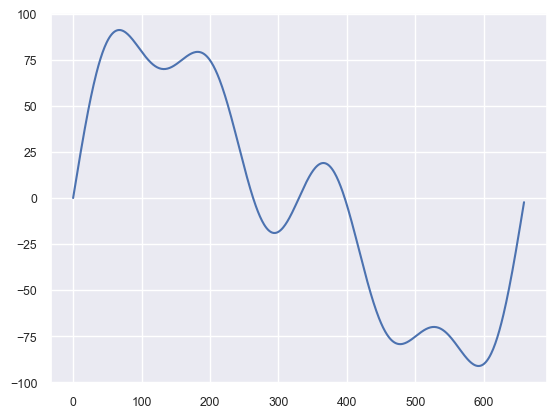

In [4]:
plt.plot(seas_gt[:660])

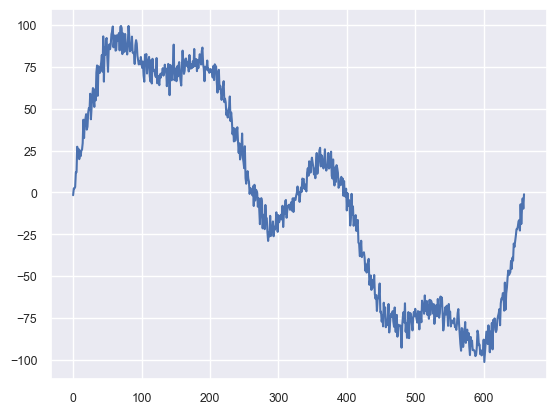

In [5]:
plt.plot(signal_large[:period]);

In [6]:
signal_small = signal_large[:int(period)*1]
signal_medium = signal_large[:int(period)*5]

# Define SD problem

In [11]:
def l2_l2d2_periodic(
    signal,
    weight,
    periodic,
    l2="norm", # or "sumsquares"
    scale=False, # scaling only for residual
    period=period, # not used yet
    solver="MOSEK"
):
    l2_func = {"norm" : cvx.norm,
               "sumsquares" : cvx.sum_squares
              }
    
    scale_seas = 1/(len(signal)-2) if scale else 1
    
    s_seas = cvx.Variable(len(signal))
    s_error = cvx.Variable(len(signal))
    weight = cvx.Constant(value=weight)
    scale_seas = cvx.Constant(value=scale_seas)
    
    objective = cvx.Minimize(
         l2_func[l2](s_error)
      + weight * scale_seas * l2_func[l2](cvx.diff(s_seas, k=2))
    )

    # Consistency and periodicity constraints
    constraints = [
        signal == s_seas + s_error
    ]
    if periodic:
        constraints.append( cvx.sum(s_seas[:period]) == 0 )
        if len(signal) > period:
            constraints.append(s_seas[period:] - s_seas[:-period] == 0)

    problem = cvx.Problem(objective=objective, constraints=constraints)
    problem.solve(solver=solver)
    
    return s_seas.value, s_error.value, problem.objective.value

# Run comparison

In [34]:
results = {}
# periodic
weight_iter_unscaled = np.logspace(3, 4, 100)
weight_iter_scaled = np.logspace(6.5, 7.5, 100)

In [35]:
def run(sig, run_type, scale, periodic=False):
    results[run_type] = {}
    weight_iter = weight_iter_scaled if scale else weight_iter_unscaled

    # results with sum_squares
    rmse_s_seas_list, rmse_s_err_list = [], []
    for w in tqdm(weight_iter):
        s_seas_ss, s_err_ss, _ = l2_l2d2_periodic(sig, weight=w, l2="sumsquares", scale=scale, periodic=periodic)
        rmse_s_seas_list.append(mse(seas_gt[:len(sig)], s_seas_ss, squared=False))
        
    results[run_type]["weight_min"] =  weight_iter[np.argmin(rmse_s_seas_list)]
    results[run_type]["rmse_s_seas_list"] = rmse_s_seas_list

In [36]:
# Small len without scaling
run(signal_small, "Small Len.", scale=False, periodic=True)

# Medium len without scaling
run(signal_medium, "Med. Len.", scale=False, periodic=True)

# Large len without scaling
run(signal_large, "Large Len.", scale=False, periodic=True)

# Small len with scaling
run(signal_small, "Small Len. Scaled", scale=True, periodic=True)

# Medium len with scaling
run(signal_medium, "Med. Len. Scaled", scale=True, periodic=True)

# Large len with scaling
run(signal_large, "Large Len. Scaled", scale=True, periodic=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


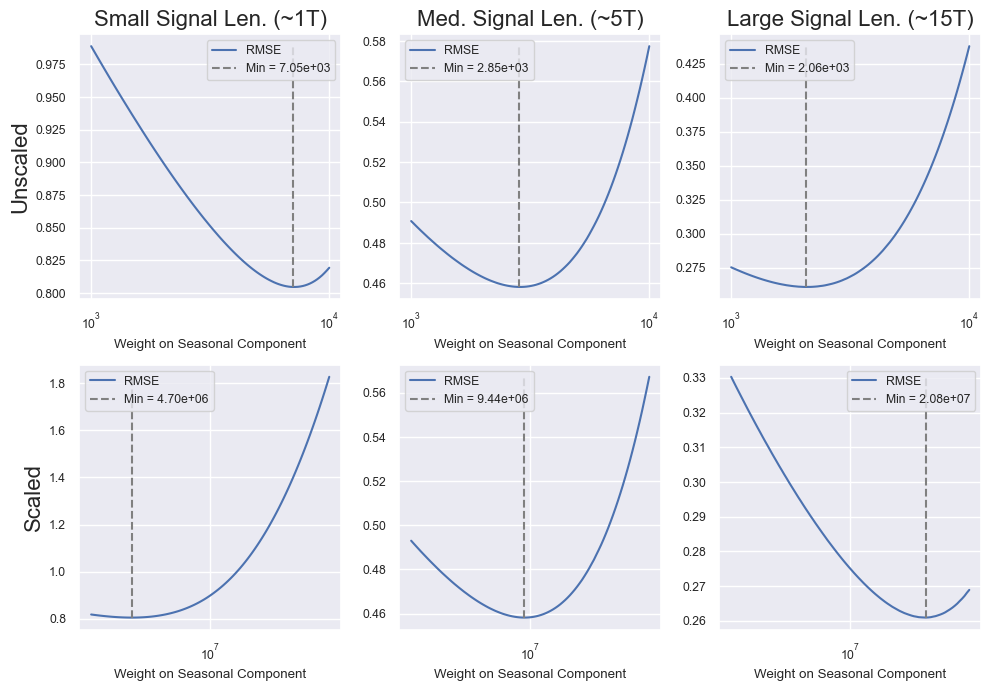

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
res_k = list(results.keys())

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        weight_iter = weight_iter_unscaled if k in list(results.keys())[:3] else weight_iter_scaled
        ax__.plot(weight_iter, results[k]["rmse_s_seas_list"], label="RMSE")
        ax__.vlines(results[k]["weight_min"], min(results[k]["rmse_s_seas_list"]), max(results[k]["rmse_s_seas_list"]), label=f'Min = {results[k]["weight_min"]:.2e}',
                linestyle="--", color="gray")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(r"Unscaled", fontsize=16)
ax[1][0].set_ylabel("Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Med. Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

for ax_ in ax[1]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")
    
for ax_ in ax[0]:
    ax_.set_xlabel("Weight on Seasonal Component")
    ax_.set_xscale("log")

plt.tight_layout()

# Show that a single weight (medium scaled vs unscaled)is sufficient for new formulation to get good decomp

## another 6 plots of decompositions

In [38]:
periodicity = True

# unscaled
weight_unscaled = results["Small Len."]["weight_min"]
results["sm_unsc_hat_min_w"] = weight_unscaled
results["sm_unsc_hat_min"], _, _ = l2_l2d2_periodic(signal_small,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)
weight_unscaled = results["Med. Len."]["weight_min"]
results["md_unsc_hat_min_w"] = weight_unscaled
results["md_unsc_hat_min"], _, _ = l2_l2d2_periodic(signal_medium,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)
weight_unscaled = results["Large Len."]["weight_min"]
results["lg_unsc_hat_min_w"] = weight_unscaled
results["lg_unsc_hat_min"], _, _ = l2_l2d2_periodic(signal_large,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

                 
# scaled
weight_scaled = results["Small Len. Scaled"]["weight_min"]
results["sm_sc_hat_min_w"] = weight_scaled
results["sm_sc_hat_min"], _, _ = l2_l2d2_periodic(signal_small,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
weight_scaled = results["Med. Len. Scaled"]["weight_min"]
results["md_sc_hat_min_w"] = weight_scaled
results["md_sc_hat_min"], _, _ = l2_l2d2_periodic(signal_medium,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
weight_scaled = results["Large Len. Scaled"]["weight_min"]
results["lg_sc_hat_min_w"] = weight_scaled
results["lg_sc_hat_min"], _, _ = l2_l2d2_periodic(signal_large,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
                 

sm_unsc_hat_min
md_unsc_hat_min
lg_unsc_hat_min
sm_sc_hat_min
md_sc_hat_min
lg_sc_hat_min


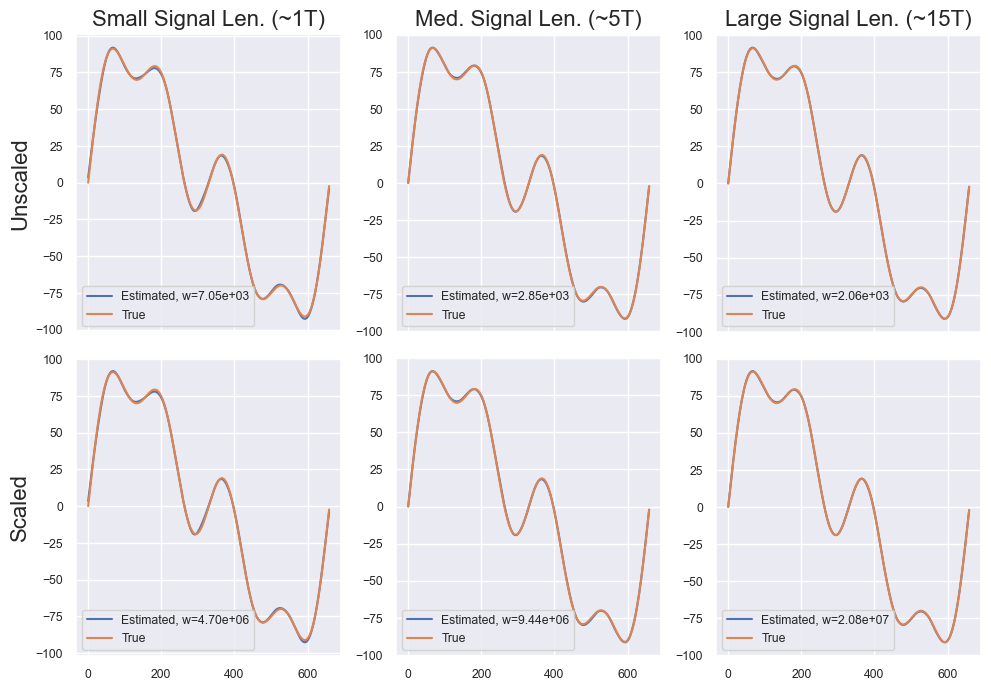

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = ["sm_unsc_hat_min", "md_unsc_hat_min", "lg_unsc_hat_min", "sm_sc_hat_min", "md_sc_hat_min", "lg_sc_hat_min"]

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        print(k)
        ax__.plot(results[k][:period], label=f"Estimated, w={results[k+'_w']:.2e}")
        ax__.plot(seas_gt[:period], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled", fontsize=16)
ax[1][0].set_ylabel(f"Scaled", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Med. Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

plt.tight_layout()

In [42]:
runs = ['Small Len.', 'Med. Len.', 'Large Len.', 'Small Len. Scaled', 'Med. Len. Scaled', 'Large Len. Scaled']
periodicity = True

# unscaled
weight_unscaled =  2.85e3

results["sm_unsc_hat"], _, _ = l2_l2d2_periodic(signal_small,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

results["md_unsc_hat"], _, _ = l2_l2d2_periodic(signal_medium,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

results["lg_unsc_hat"], _, _ = l2_l2d2_periodic(signal_large,
                                                                                     weight=weight_unscaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=False, periodic=periodicity)

                 
# scaled
weight_scaled = 9.44e6

results["sm_sc_hat"], _, _ = l2_l2d2_periodic(signal_small,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)

results["md_sc_hat"], _, _ = l2_l2d2_periodic(signal_medium,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)

results["lg_sc_hat"], _, _ = l2_l2d2_periodic(signal_large,
                                                                                     weight=weight_scaled, 
                                                                                     l2="sumsquares", 
                                                                                     scale=True, periodic=periodicity)
                 

sm_unsc_hat
md_unsc_hat
lg_unsc_hat
sm_sc_hat
md_sc_hat
lg_sc_hat


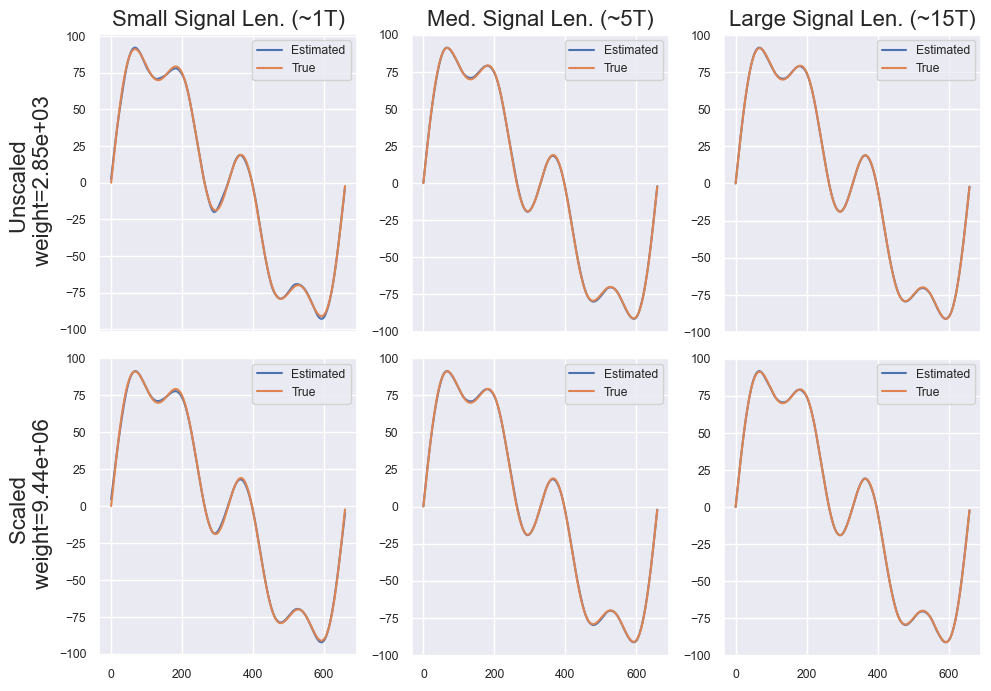

In [43]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, figsize=(10,7))
res_k = ["sm_unsc_hat", "md_unsc_hat", "lg_unsc_hat", "sm_sc_hat", "md_sc_hat", "lg_sc_hat"]

for ax_ in ax:
    for ax__, k in zip(ax_, res_k):
        print(k)
        ax__.plot(results[k][:period], label="Estimated")
        ax__.plot(seas_gt[:period], label="True")
        ax__.legend()
    res_k = res_k[3:]
        
ax[0][0].set_ylabel(f"Unscaled \n weight={weight_unscaled:.2e}", fontsize=16)
ax[1][0].set_ylabel(f"Scaled \n weight={weight_scaled:.2e}", fontsize=16)
ax[0][0].set_title("Small Signal Len. (~1T)", fontsize=16)
ax[0][1].set_title("Med. Signal Len. (~5T)", fontsize=16)
ax[0][2].set_title("Large Signal Len. (~15T)", fontsize=16)

plt.tight_layout()